Classifying Names with a Character-Level RNN
============================================

We will be building and training a basic character-level Recurrent
Neural Network (RNN) to classify words.

A character-level RNN reads words as a series of characters -outputting
a prediction and \"hidden state\" at each step.

Specifically, we\'ll train on a few thousand surnames from 14 languages
of origin, and predict which language a name is from based on the
spelling.

Preparing Torch
===============

Set up torch to default to the right device use GPU acceleration
depending on your hardware (CPU or CUDA).


In [1]:
import torch

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cpu


Preparing the Data
==================

Download the data ("names.zip") from the virtual campus . Included in the `data/names` directory are 14 text files named as
`[Language].txt`. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

The first step is to define and clean our data. Initially, we need to
convert Unicode to plain ASCII to limit the RNN input layers. This is
accomplished by converting Unicode strings to ASCII and allowing only a small set of allowed characters.


In [2]:
import string
import unicodedata

# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)
print(n_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

58


Here\'s an example of converting a unicode alphabet name to plain ASCII.
This simplifies the input layer


In [3]:
print (f"converting 'Ślusàrski' to {unicodeToAscii('Ślusàrski')}")

converting 'Ślusàrski' to Slusarski


Turning Names into Tensors
==========================

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a \"one-hot vector\" of size
`<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at
index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix
`<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we\'re just using a batch size of 1 here.


In [4]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

Here are some examples of how to use `lineToTensor()` for a single and
multiple character string.


In [5]:
print (f"The letter 'a' becomes {lineToTensor('a')}") #notice that the first position in the tensor = 1
print (f"The name 'Ahn' becomes {lineToTensor('Ahn')}") #notice 'A' sets the 27th index to 1print (f"The letter 'a' becomes {lineToTensor('a')}") #notice that the first position in the tensor = 1

The letter 'a' becomes tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]])
The name 'Ahn' becomes tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Next, we need to combine all our examples into a dataset so we can
train, test and validate our models. For this, we will use the [Dataset
and
DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
classes to hold our dataset. Each Dataset needs to implement three
functions: `__init__`, `__len__`, and `__getitem__`. By implementing these three methods, your NamesDataset class becomes compatible with PyTorch's DataLoader, enabling efficient batching and iteration over your data during training and evaluation.

In [6]:
from io import open
import glob
import os
import time

import torch
from torch.utils.data import Dataset

class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

Here we can load our example data into the `NamesDataset`


In [7]:
#alldata = NamesDataset("data/names")
alldata = NamesDataset("/content/sample_data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 19733 items of data
example = (tensor([10]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]]), 'Japanese', 'Abe')


Using the dataset object allows us to easily split the data into train and test sets. Here we create a 85/15.

In [8]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 16774, validation examples = 2959


Creating the RNN
====================

This CharRNN class implements an RNN with three components. First, we
use the [nn.RNN
implementation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html).
Next, we define a layer that maps the RNN hidden layers to our output.
And finally, we apply a `softmax` function.


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

We can then create an RNN with 58 input nodes, 128 hidden nodes, and 18
outputs:


In [10]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(58, 128)
  (h2o): Linear(in_features=128, out_features=14, bias=True)
  (softmax): LogSoftmax(dim=1)
)


After that we can pass our Tensor to the RNN to obtain a predicted
output. From these output classes, the maximum is obtained, so a class is assigned (both numerical and the label of the language).


In [11]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.7150, -2.6691, -2.6903, -2.6451, -2.4607, -2.7812, -2.6667, -2.5875,
         -2.6068, -2.7700, -2.5813, -2.6891, -2.6039, -2.5311]],
       grad_fn=<LogSoftmaxBackward0>)
('English', 4)


Training the Network
====================

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it\'s wrong.

We do this by defining a `train()` function which trains the model on a
given dataset using minibatches. RNNs RNNs are trained similarly to
other networks; therefore, for completeness, we include a batched
training method here. The loop (`for i in batch`) computes the losses
for each of the items in the batch before adjusting the weights. This
operation is repeated until the number of epochs is reached.


In [12]:
import random
import numpy as np

def train(rnn, training_data, n_epoch = 30, n_batch_size = 64, report_every = 5, learning_rate = 0.05, criterion = nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

We can now train a dataset with minibatches for a specified number of
epochs (def: 30 epochs, learning_rate: 0.05, report every 5 epochs). The number of epochs for this example is reduced to speed up the
build. You can get better results with different parameters.


In [13]:
start = time.time()
all_losses = train(rnn, train_set, n_epoch=30, learning_rate=0.05, report_every=5)
end = time.time()
print(f"training took {end-start}s")



training on data set with n = 16774
5 (100%): 	 average batch loss = 0.9018914014853524
training took 72.8947525024414s


Plotting the Results
====================

Plotting the historical loss from `all_losses` shows the network
learning:


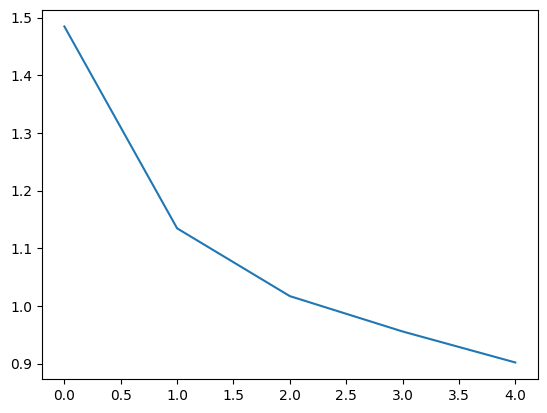

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a **confusion matrix**, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with `evaluate()`,
which is the same as `train()` minus the backprop.

F1-score and precision (in the weighted form, to take into account for large and small size classes) are also printed.

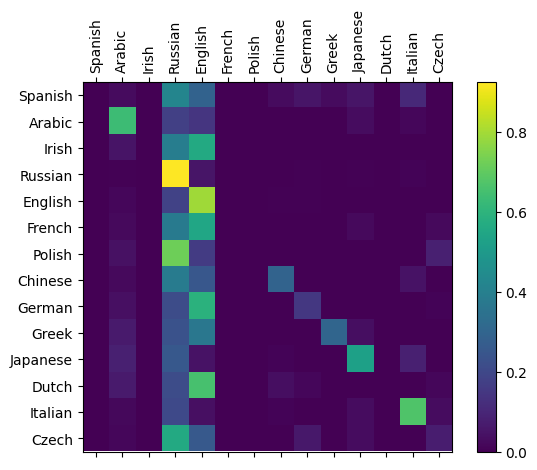


Accuracy: 0.7158
F1-Score (weighted): 0.6732


In [15]:
import sklearn.metrics

def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))
    all_true_labels = []
    all_predictions = []

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)

            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

            all_true_labels.append(label_i)
            all_predictions.append(guess_i)

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

    # Calculate and print additional metrics
    accuracy = sklearn.metrics.accuracy_score(all_true_labels, all_predictions)
    f1 = sklearn.metrics.f1_score(all_true_labels, all_predictions, average='weighted')

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")


evaluate(rnn, test_set, classes=alldata.labels_uniq)

Tasks:
=========

- Understand the code.

- Get better results by adjusting the hyperparameters, such as
        changing the size of the hidden layer, number of epochs, batch size, and learning rate.
